# CSV/Excel Analysis Agent


## Overview

This tutorial covers how to create an agent that performs analysis on the `Pandas` DataFrame loaded from CSV or Excel files. The agent generates `Pandas` queries to analyze the dataset.

Pandas is a powerful data manipulation and analysis library for Python. It provides data structures like series and dataframes to effectively easily clean, transform, and analyze large datasets and integrates seamlessly with other python libraries, such as numPy and matplotlib. It offers powerful functions for data transformation, aggregation, and visualization, which are crucial for effective analysis.

### Table of Contents

- [Overview](#overview)
- [Environment Setup](#environment-setup)
- [Sample Data](#sample-data)
- [Create an Analysis Agent](#create-an-analysis-agent)

### References
- [LangChain Documentation : create_pandas_dataframe_agent](https://python.langchain.com/api_reference/experimental/agents/langchain_experimental.agents.agent_toolkits.pandas.base.create_pandas_dataframe_agent.html)
----

## Environment Setup


In [1]:
# import getenv
import os
import getpass
import dotenv
# Load environment variables from .env file
dotenv.load_dotenv()
# Import Azure OpenAI
from langchain_openai import AzureChatOpenAI
from IPython.display import Markdown
from langchain_core.messages import HumanMessage, SystemMessage

## Sample Data

Document Used for Practice : **Titanic Dataset**
- File Name : titanic.csv
- Link : [Stanford CS109 Material](https://web.stanford.edu/class/archive/cs/cs109/cs109.1166/stuff/)
- Reference : [Titanic - Machine Learning from Disaster (Kaggle)](https://www.kaggle.com/c/titanic/data)

*Please copy the downloaded file to the data folder for practice.*

In [2]:
import pandas as pd

# Load CSV file
df = pd.read_csv("./data/titanic.csv")
# In case of loading an Excel file
# df = pd.read_excel("./data/titanic.xlsx", sheet_name="Sheet1")
df.head()

,Survived,Pclass,Name,Sex,Age,Siblings/Spouses Aboard,Parents/Children Aboard,Fare
0,0,3,Mr. Owen Harris Braund,male,22.0,1,0,7.2500
1,1,1,Mrs. John Bradley (Florence Briggs Thayer) Cum...,female,38.0,1,0,71.2833
2,1,3,Miss. Laina Heikkinen,female,26.0,0,0,7.9250
3,1,1,Mrs. Jacques Heath (Lily May Peel) Futrelle,female,35.0,1,0,53.1000
4,0,3,Mr. William Henry Allen,male,35.0,0,0,8.0500


## Create an Analysis Agent

Define an agent to analyze the data loaded from CSV or Excel files using `create_pandas_dataframe_agent` . 

This agent needs a `PythonAstREPLTool` to execute Python codes. Also, a custom function is defined to print the intermediate steps of the agent execution.

In [3]:
from langchain_experimental.tools import PythonAstREPLTool

# Create a tool to execute Python codes.
python_tool = PythonAstREPLTool()

# Load the DataFrame on locals["df"]
python_tool.locals["df"] = df

In [4]:
#%pip install tabulate
#%pip install seaborn

In [5]:
from langchain_experimental.agents.agent_toolkits import create_pandas_dataframe_agent
from langchain_openai import AzureChatOpenAI

# Create an agent
agent = create_pandas_dataframe_agent(
    AzureChatOpenAI(
    azure_endpoint=os.getenv("AZURE_OPENAI_ENDPOINT"),
    azure_deployment=os.getenv("AZURE_OPENAI_DEPLOYMENT_NAME"),
    api_key=os.getenv("AZURE_OPENAI_API_KEY"),
    openai_api_version=os.getenv("OPENAI_API_VERSION"),
),
    df,
    verbose=False,
    agent_type="tool-calling",
    allow_dangerous_code=True,
    prefix="You are a professional data analyst. "
    "You must use Pandas DataFrame(`df`) to answer user's queries. "
    "\n\n[IMPORTANT] DO NOT create or overwrite the `df` variable in your code. \n\n"
    "For visualization of the analyzed result, please use `plt.show()` at the end of your code. "
    "I prefer seaborn for visualization, but you can use matplotlib as well."
    "\n\n<Visualization Preference>\n"
    "- `muted` cmap, white background, and no grid for your visualization."
    "\nRecomment to set palette parameter for seaborn plot.",  # Add additional instructions to the default prompt
)

In [6]:
from langchain_core.agents import AgentStep


# Define a function to stream intermediate steps of executing the agent.
def stream_response(query):
    response = agent.stream({"input": query})
    for step in response:
        if "actions" in step:
            if step["actions"][0].tool == "python_repl_ast":
                tool_input = step["actions"][0].tool_input
                for k, v in tool_input.items():
                    if k == "query":
                        print(f"---- Code Begins ----")
                        print(v)
                        result = python_tool.invoke({"query": v})
                        print(result)
                        print(f"---- Code Ends ----")
        elif "steps" in step:
            print(f"---- Message Begins ----")
            for observation in step["steps"]:
                if isinstance(observation, AgentStep):
                    print(getattr(observation, "observation", None))
            print(f"---- Message Ends ----")
        elif "output" in step:
            print(f"---- Final Answer Begins ----")
            print(step["output"])
            print(f"---- Final Answer Ends ----")

---- Code Begins ----
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate correlation matrix
correlation_matrix = df.corr()

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Draw the heatmap
sns.heatmap(correlation_matrix, annot=True, cmap="muted", square=True, linewidths=.5)

# Set the aesthetics
plt.title('Correlation Heatmap', fontsize=16)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()
ValueError: could not convert string to float: 'Mr. Owen Harris Braund'
---- Code Ends ----
---- Message Begins ----
ValueError: could not convert string to float: 'Mr. Owen Harris Braund'
---- Message Ends ----
---- Code Begins ----
# Select only numeric columns for correlation
numeric_df = df.select_dtypes(include=['number'])

# Calculate correlation matrix
correlation_matrix = numeric_df.corr()

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Draw the heatmap
sns.heatmap(correlation_matrix, annot=True, cmap="muted", square=True, linewidths=.5)



<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

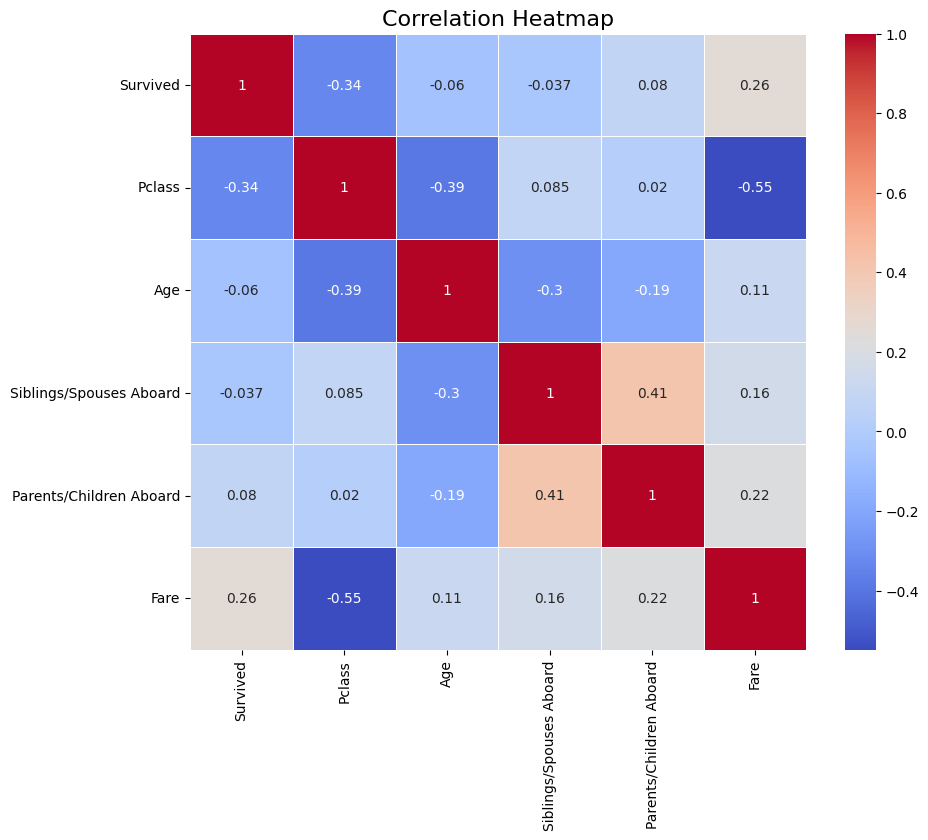

---- Code Begins ----
# Select only numeric columns for correlation
numeric_df = df.select_dtypes(include=['number'])

# Calculate correlation matrix
correlation_matrix = numeric_df.corr()

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Draw the heatmap
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", square=True, linewidths=.5)

# Set the aesthetics
plt.title('Correlation Heatmap', fontsize=16)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

---- Code Ends ----


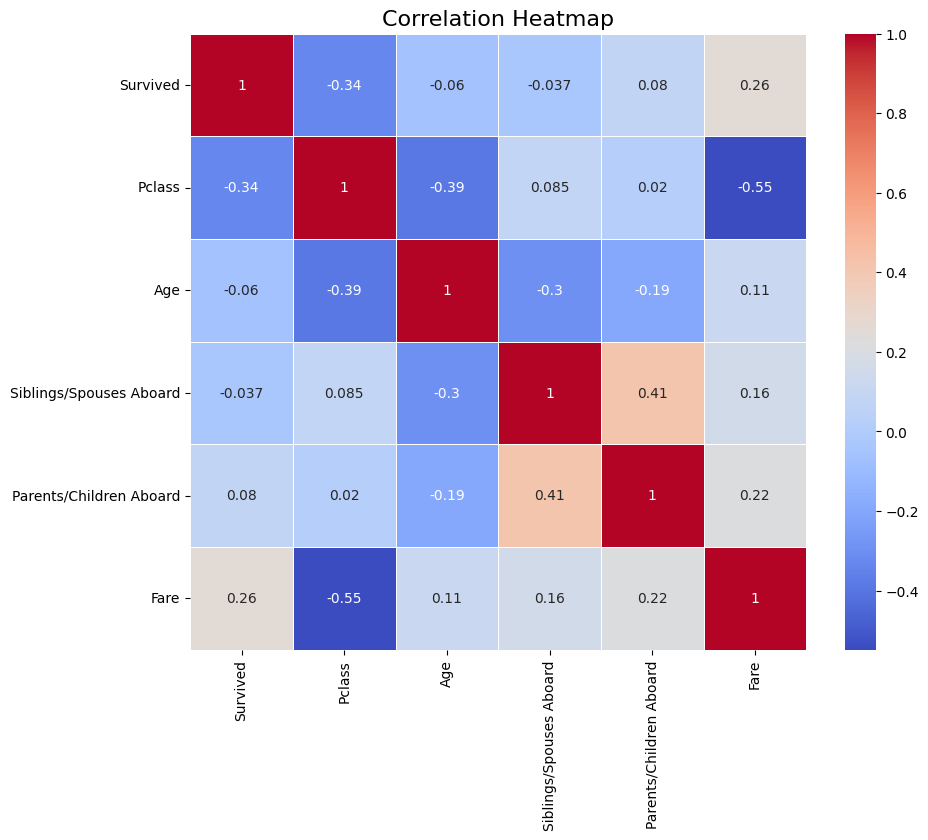

---- Message Begins ----

---- Message Ends ----
---- Final Answer Begins ----
The correlation heatmap has been successfully displayed using the "coolwarm" colormap. Let me know if you need any other visualizations or analyses!
---- Final Answer Ends ----


In [7]:
stream_response("Visualize correlations as a heatmap.")

In [8]:
stream_response("How many rows are there?")

---- Code Begins ----
len(df)
887
---- Code Ends ----
---- Message Begins ----
887
---- Message Ends ----
---- Final Answer Begins ----
The DataFrame contains 887 rows.
---- Final Answer Ends ----


---- Code Begins ----
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate survival rates by gender
survival_rates = df.groupby('Sex')['Survived'].mean()

# Plot the survival rates
sns.set_theme(style="white", palette="muted")
sns.barplot(x=survival_rates.index, y=survival_rates.values, palette='muted')
plt.title('Survival Rates by Gender')
plt.ylabel('Survival Rate')
plt.xlabel('Gender')
plt.show()

survival_rates


<string>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



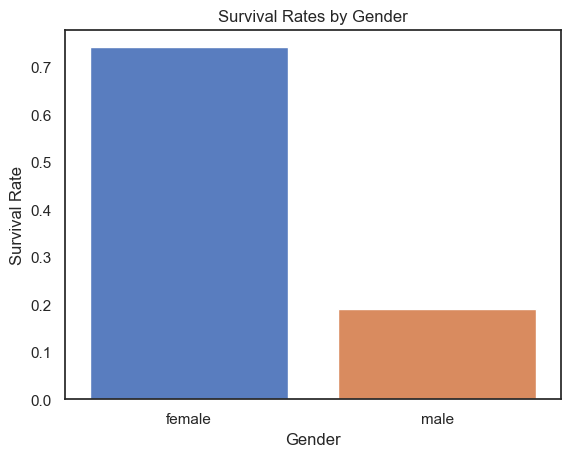

Sex
female    0.742038
male      0.190227
Name: Survived, dtype: float64
---- Code Ends ----


<string>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



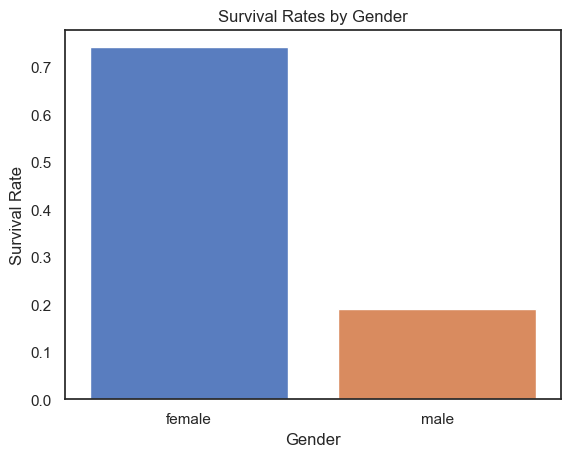

---- Message Begins ----
Sex
female    0.742038
male      0.190227
Name: Survived, dtype: float64
---- Message Ends ----
---- Final Answer Begins ----
The survival rates by gender are as follows:
- Female: 74.2%
- Male: 19.0%

The difference in survival rates between women and men is significant, with women having a much higher survival rate than men. The visualization for this data has been displayed.
---- Final Answer Ends ----


In [9]:
stream_response("What is the difference in survival rates between men and women?")

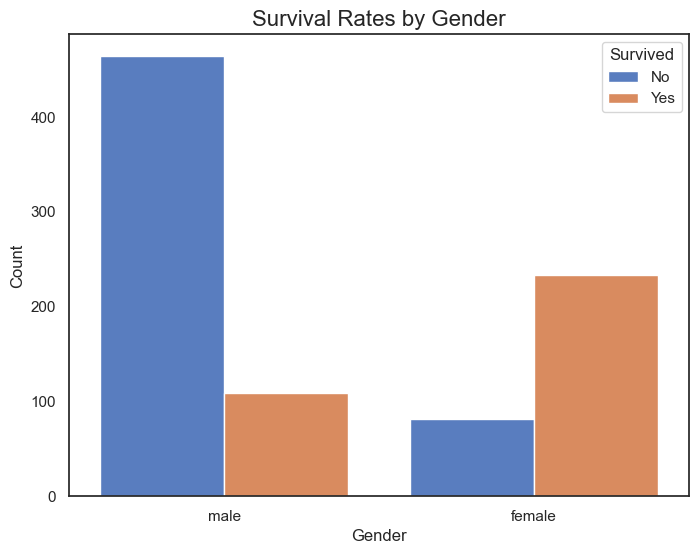

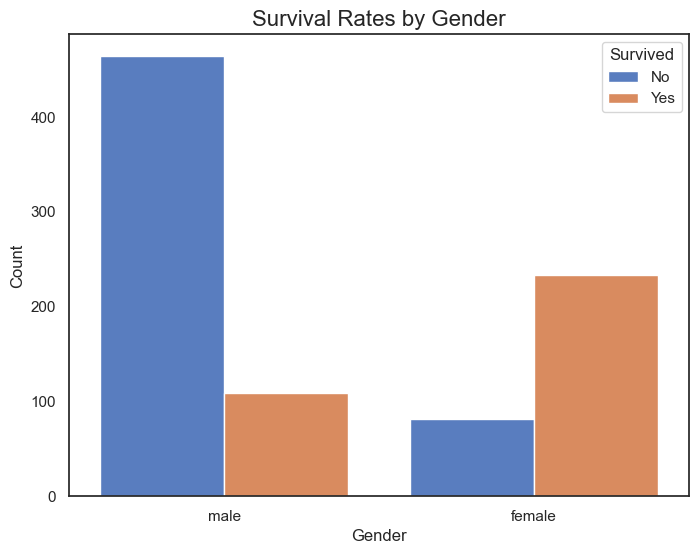

---- Code Begins ----
import seaborn as sns
import matplotlib.pyplot as plt

# Setting seaborn style
sns.set_theme(style="white", palette="muted")

# Create barplot
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='Sex', hue='Survived', palette='muted')

# Add title and labels
plt.title('Survival Rates by Gender', fontsize=16)
plt.xlabel('Gender', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.legend(title='Survived', labels=['No', 'Yes'])

# Display plot
plt.show()

---- Code Ends ----
---- Message Begins ----

---- Message Ends ----
---- Final Answer Begins ----
I have visualized the survival rates of male and female passengers in a bar plot, separated by gender with survival status indicated by the colors. Check the plot for insights.
---- Final Answer Ends ----


In [10]:
stream_response(
    "Visualize the survival rates of male and female passengers in a barplot."
)

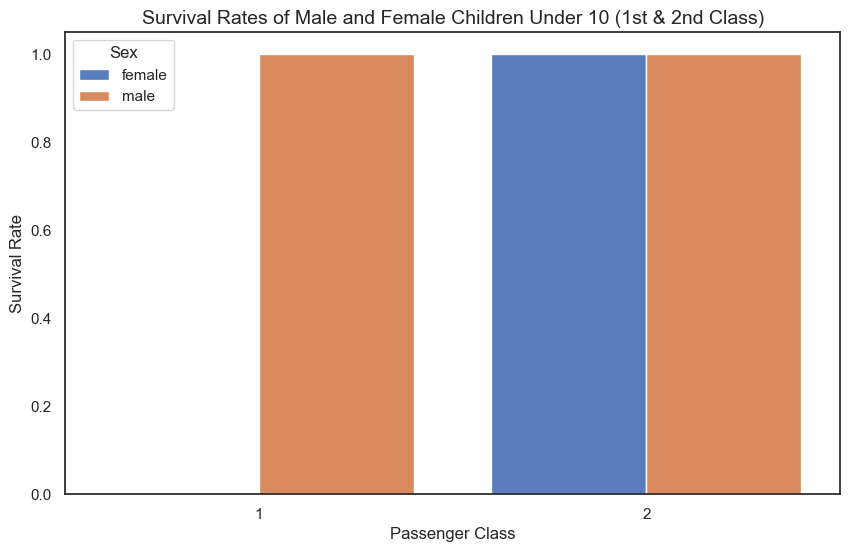

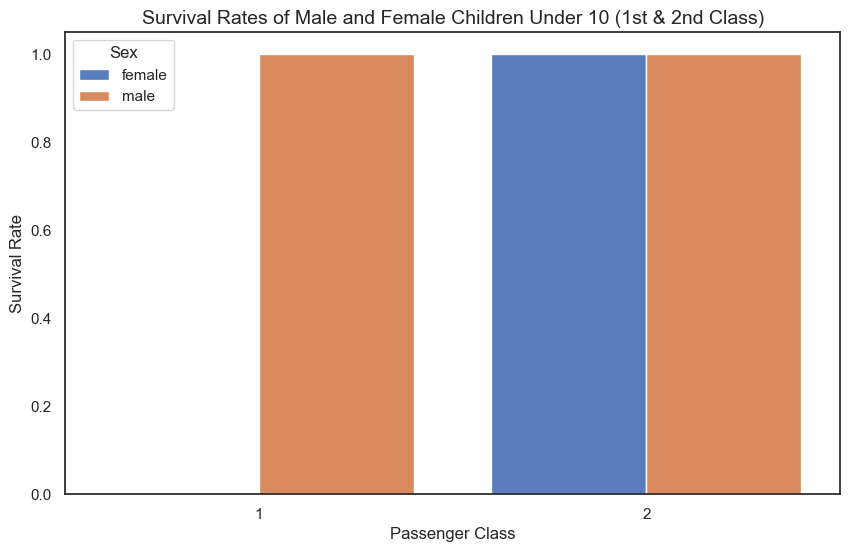

---- Code Begins ----
import seaborn as sns
import matplotlib.pyplot as plt

# Filter data for children under 10 years old and belonging to 1st and 2nd class
filtered_df = df[(df['Age'] < 10) & (df['Pclass'].isin([1, 2]))]

# Create a bar plot to visualize survival rates by sex and Passenger Class
plt.figure(figsize=(10, 6))
sns.set_theme(style="white", palette="muted")
ax = sns.barplot(
    data=filtered_df,
    x='Pclass', 
    y='Survived', 
    hue='Sex',
    palette="muted"
)
ax.set_title('Survival Rates of Male and Female Children Under 10 (1st & 2nd Class)', fontsize=14)
ax.set_xlabel('Passenger Class', fontsize=12)
ax.set_ylabel('Survival Rate', fontsize=12)

plt.show()

---- Code Ends ----
---- Message Begins ----

---- Message Ends ----
---- Final Answer Begins ----
The bar plot visualizing the survival rates of male and female children under 10 years in 1st and 2nd class has been displayed. You can now analyze the survival trends based on gender and class for young children.

In [11]:
stream_response(
    "Visualize the survival rates of male and female children under 10 in 1st and 2nd class."
)

In [12]:
stream_response(
    "what other visualization questions could I ask based on the contents of the CSV data file?."
)

---- Final Answer Begins ----
Based on the contents of the Titanic dataset (preview provided in the CSV), there are various visualization questions you can ask to uncover trends, relationships, and insights. Here are several categories and examples of questions:

---

### **Survival Analysis**
1. How does the survival rate differ by passenger class (Pclass)?
2. Visualize the survival rate by gender (Sex).
3. What is the survival rate by age group? (e.g., grouping by children, adults, and elderly).

---

### **Demographics Analysis**
4. What is the age distribution of passengers?
5. Compare the age distribution by gender or class.
6. What is the proportion of males versus females in each passenger class?

---

### **Fare Insights**
7. Visualize the fare distribution across passenger classes.
8. Is there a correlation between fare and survival rate?
9. Compare fare distribution by survival status (survived vs. not survived).

---

### **Family Relationships**
10. Visualize the number of 

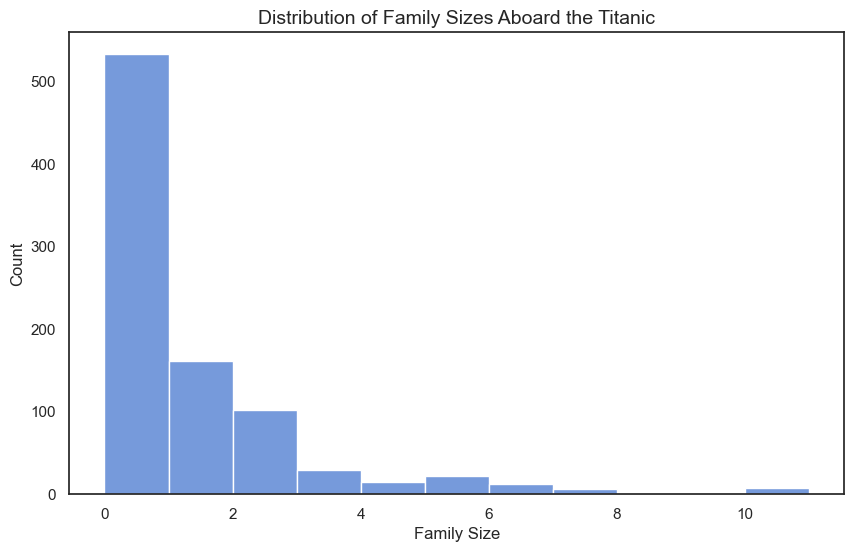

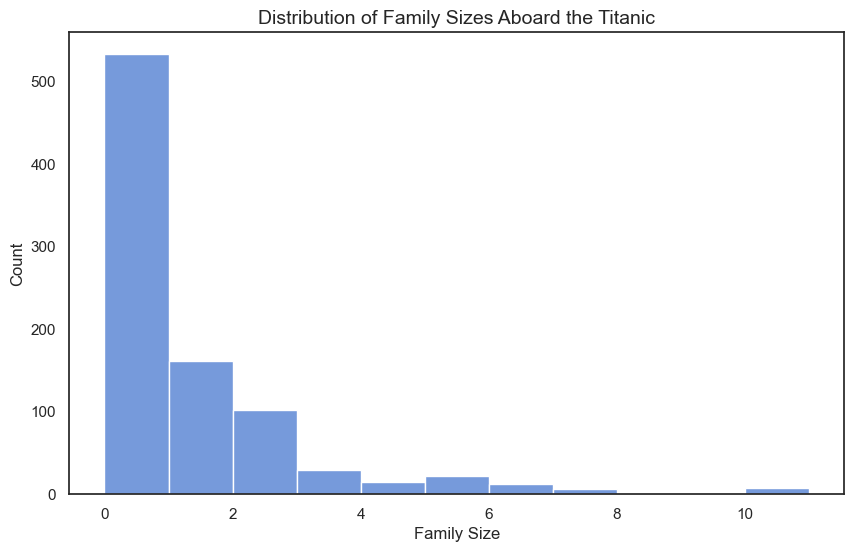

---- Code Begins ----
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate family size
family_size = df['Siblings/Spouses Aboard'] + df['Parents/Children Aboard']
df['Family Size'] = family_size

# Set aesthetic parameters
sns.set_theme(style="white", palette="muted")

# Plot the distribution of family sizes
plt.figure(figsize=(10, 6))
sns.histplot(df['Family Size'], bins=range(family_size.min(), family_size.max() + 2), kde=False)
plt.title('Distribution of Family Sizes Aboard the Titanic', fontsize=14)
plt.xlabel('Family Size', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.show()

---- Code Ends ----
---- Message Begins ----

---- Message Ends ----
---- Final Answer Begins ----
The distribution of family sizes aboard the Titanic has been visualized in a histogram. The chart illustrates how the sizes of families (including siblings/spouses and parents/children aboard) were distributed among passengers, along with the frequency of each family size.
---- Final Answer En

In [13]:
stream_response(
    "What is the distribution of family sizes aboard the Titanic?"
)